# Grapheme Embedding Using PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm

import re
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint,shuffle

In [3]:
print(vocab)

NameError: name 'vocab' is not defined

In [4]:
text = open("data/francais.txt",encoding='latin-1').read()
text = (re.sub(r'[^\w\s]','',text.lower())).replace(' ','')

tokens=[]
vocab = {'$','£'}
for term in text.split('\n'):
    #print(set(term))
    vocab.update(term)
    tokens.append(list("$$"+term+"£"))
shuffle(tokens)
vocab = list(vocab)
v=len(vocab)    

In [5]:
def graph2int(graph):
    return vocab.index(graph)
    
def int2graph(index):
    return vocab[index]

def int2vec(integer):
    vec=np.zeros(len(vocab))
    vec[integer]=1
    return vec

def graph2vec(graph):
    return (int2vec(graph2int(graph)))

def vec2graph(vec):
    return (int2graph(np.argmax(vec)))

In [6]:
windowSize = 2
tokens = [tokenSet for tokenSet in tokens if len(tokenSet)>=6]
print(tokens[0])

['$', '$', 'c', 'o', 'm', 'm', 'e', 'n', 't', 'e', 'r', 'a', 'i', 't', '£']


In [7]:
x_data = torch.empty(size=(1,2,v))
y_data = torch.empty(size=(1,1))

freqs= torch.zeros(size=(1,v))

i=0
N=len(tokens)
for word in tqdm.tqdm(tokens[:5000]):
    wc = len(word)
    for graph_i in range(wc-2): 
        data_sample = torch.tensor([graph2vec(word[graph_i]), graph2vec(word[graph_i+1])]).unsqueeze(0).float()
        x_data = torch.cat([x_data,data_sample])
        label_sample = torch.tensor([graph2int(word[graph_i+2])]).unsqueeze(0).float()
        y_data = torch.cat([y_data,label_sample])
        freqs += graph2vec(word[graph_i+2])
        
    

100%|██████████| 5000/5000 [04:02<00:00, 20.65it/s]


In [8]:
    
x_data=x_data[1:,:,:]
y_data=y_data[1:,:]

In [9]:
print(x_data.shape)
print(y_data.shape)

torch.Size([54029, 2, 45])
torch.Size([54029, 1])


## PyTorch

### Encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self,grapheme_shape,hidden_units,embedding_units):
        super(Encoder,self).__init__()
        self.word_shape = grapheme_shape
        self.hidden_units = hidden_units
        self.embedding_units = embedding_units
        
        self.weights_1 = nn.Parameter(torch.empty(size=(hidden_units, grapheme_shape), requires_grad=True))
        nn.init.normal_(self.weights_1)
        
        self.weights_2 = nn.Parameter(torch.empty(size=(embedding_units, hidden_units), requires_grad=True))
        nn.init.normal_(self.weights_2)
        
        self.bias1 = nn.Parameter(torch.zeros(hidden_units), requires_grad=True)
        self.bias2 = nn.Parameter(torch.zeros(embedding_units), requires_grad=True)

    def forward(self,inputs):
        out = F.linear(inputs, self.weights_1, self.bias1)
        out = nn.ReLU().forward(out)
        out = F.linear(out, self.weights_2,self.bias2)
        out = nn.ReLU().forward(out)
        return out
    

        

### Graph2Vec

In [11]:
class Decoder(nn.Module):
    def __init__(self,embedding_units,layer_1_n,grapheme_shape,encoder):
        super(Decoder,self).__init__()
        self.e = encoder
        self.embedding_units=embedding_units
        self.layer_1_n = layer_1_n

        self.weights_layer1 = nn.Parameter(torch.empty(size=(self.layer_1_n, self.embedding_units*2), requires_grad=True))
        nn.init.normal_(self.weights_layer1)
        self.bias_layer1 = nn.Parameter(torch.zeros(layer_1_n), requires_grad=True)

        self.weights_output = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output)
        self.bias = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
      
    def forward(self,inputs):
        embedding1 = self.e.forward(inputs[:,0])
        embedding2 = self.e.forward(inputs[:,1])

        out = torch.cat((embedding1,embedding2),dim=1)

        out = nn.ReLU().forward(F.linear(out, self.weights_layer1, self.bias_layer1))

        out = nn.ReLU().forward(F.linear(out, self.weights_output, self.bias))
   
        return out
    
    def encode(self,inputs):
        return self.e.forward(inputs)


In [12]:
train_ratio = 0.80
batch_size = 256

trn_n = int(x_data.shape[0] * 0.8)
batches = (int(trn_n/batch_size))

x_trn = x_data[:trn_n,:,:].clone()
y_trn = y_data[:trn_n,:].clone()

x_val = x_data[trn_n:,:,:].clone()
y_val = y_data[trn_n:,:].clone()

In [13]:
metric_dict = {'losses_trn': [],'losses_val':[]} 
encoder =  Encoder(grapheme_shape=v,hidden_units=10,embedding_units=10)
decoder = Decoder(embedding_units=10,layer_1_n=15,grapheme_shape=v,encoder=encoder)
optimizer = optim.Adam(decoder.parameters(), amsgrad=False, weight_decay=0.0)

trn_loss = nn.NLLLoss(weight=freqs.float())
val_loss = nn.NLLLoss()

for epoch in range(100):
    print("Epoch:" + str(epoch))
    epoch_trn_loss_sum = 0
    for batch in (range(batches)):
        x_batch = x_trn[batch_size*batch:batch_size*(batch+1)]
        y_batch = y_trn[batch_size*batch:batch_size*(batch+1)]
        
        out = decoder.forward(x_batch)
        log_softmax = F.log_softmax(out, dim=1).unsqueeze(2)
        
       
        
        NLL_Loss = trn_loss(log_softmax,y_batch.long()) 
        optimizer.zero_grad()
        NLL_Loss.backward()
        optimizer.step()
        epoch_trn_loss_sum += NLL_Loss.item()
        
    out_val = decoder.forward(x_val)
    log_val_softmax = F.log_softmax(out_val, dim=1).unsqueeze(2)
    NLL_val_loss = trn_loss(log_val_softmax, y_val.long())
    
    epoch_trn_loss = epoch_trn_loss_sum/batches
    print("Validation Loss: "+str(NLL_val_loss.item()))
    print("Train Loss:      "+str(epoch_trn_loss))
    print("\n")
   # print("Val: "+str(val_loss.item()))
    metric_dict['losses_trn'].append(NLL_Loss.item())
    metric_dict['losses_val'].append(epoch_trn_loss)

Epoch:0
Validation Loss: 8.965091705322266
Train Loss:      17.11808415253957


Epoch:1
Validation Loss: 4.410715103149414
Train Loss:      6.062275233722868


Epoch:2
Validation Loss: 3.332700490951538
Train Loss:      3.6986660928953263


Epoch:3
Validation Loss: 3.00250244140625
Train Loss:      3.1101183621656325


Epoch:4
Validation Loss: 2.8256444931030273
Train Loss:      2.8746701734406606


Epoch:5
Validation Loss: 2.6824233531951904
Train Loss:      2.726026767776126


Epoch:6
Validation Loss: 2.5256476402282715
Train Loss:      2.575537241640545


Epoch:7
Validation Loss: 2.4050846099853516
Train Loss:      2.4287619647525607


Epoch:8
Validation Loss: 2.3271660804748535
Train Loss:      2.329120709782555


Epoch:9
Validation Loss: 2.2733631134033203
Train Loss:      2.2629564560595012


Epoch:10
Validation Loss: 2.234447479248047
Train Loss:      2.218474256140845


Epoch:11
Validation Loss: 2.203754425048828
Train Loss:      2.1859606163842336


Epoch:12
Validation Loss: 2

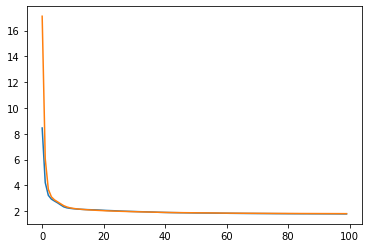

In [14]:
plt.plot(metric_dict['losses_trn'][:100])
plt.plot(metric_dict['losses_val'][:100])

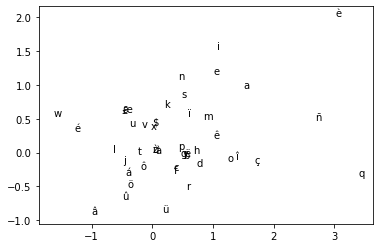

In [15]:
embeddings = np.zeros(shape=(len(vocab),10))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1



embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]

low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=low_d_embed[:,0]
y=low_d_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y,color='white')

for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

In [16]:
n=randint(0,x_trn.shape[0])



input = x_trn[n,:,:].unsqueeze(0)
output = y_trn[n,:]

out=decoder.forward(input)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output.int().numpy())

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]


print(inp_let)
print("Prediction: " + ''.join(inp_let)+" "+str(vocab[p]))
print("True:       " + ''.join(inp_let)+" "+str(vocab[o[0]]))

['$', 'g']
Prediction: $g r
True:       $g o


In [17]:
n=randint(0,len(tokens))
token=(tokens[n])[:-1]
print(token)

input = token[-3:-1]

#input = x_trn[n,:,:].unsqueeze(0)
output = token[-1:][0]

input = torch.tensor([graph2vec(input[0]),graph2vec(input[1])]).unsqueeze(0).float()

out=decoder.forward(input)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output)

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]
print(inp_let)
print(p)


print(inp_let)
print("Prediction: " + ''.join(token[:-1])+" "+str(vocab[p]))
print("True:       " + ''.join(token[:-1])+" "+str(output))

['$', '$', 'é', 'p', 'a', 'n', 'd', 'r', 'i', 'o', 'n', 's']
['o', 'n']
16
['o', 'n']
Prediction: $$épandrion s
True:       $$épandrion s


In [31]:
n=randint(0,len(tokens))
token=(tokens[n])[:-1]

sentence = []

for i in range(10):
    string = "$$"

    while True:

        input=string[-2:]
        input = torch.tensor([graph2vec(input[0]),graph2vec(input[1])]).unsqueeze(0).float()

        out=decoder.forward(input)
        probs = F.softmax(out, dim=1).detach().numpy()[0]

        sample = np.random.multinomial(1, probs)
        ids = np.argmax(sample)

        #p=(log_softmax.argmin(dim=1).detach().numpy()[0])

        grapheme = str(vocab[ids])

        string+=grapheme
        if grapheme =="£":
            break
        
    #print(string)
    string = string.split('$')[2:][0]
    string = string.split('£')[:-1][0]
    sentence.append(string)

print(' '.join(sentence))

lamois nerais orsatermions rraies ins emons eromeriant es rieonne erionr


In [849]:
embeddings = np.zeros(shape=(len(vocab),10))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1
    
l=0
for e in (embeddings):
    dists=(np.square(embeddings-e).sum(axis=1))
    nearest_idx=(np.argsort(dists)[1])
    print("Nearest neighbour of "+vocab[l]+" : "+vocab[nearest_idx])
    l+=1
    

Nearest neighbour of a : c
Nearest neighbour of b : p
Nearest neighbour of c : f
Nearest neighbour of d : z
Nearest neighbour of e : s
Nearest neighbour of f : x
Nearest neighbour of g : q
Nearest neighbour of h : r
Nearest neighbour of i : k
Nearest neighbour of j : w
Nearest neighbour of k : i
Nearest neighbour of l : d
Nearest neighbour of m : x
Nearest neighbour of n : r
Nearest neighbour of o : a
Nearest neighbour of p : b
Nearest neighbour of q : s
Nearest neighbour of r : n
Nearest neighbour of s : t
Nearest neighbour of t : s
Nearest neighbour of u : b
Nearest neighbour of v : $
Nearest neighbour of w : $
Nearest neighbour of x : f
Nearest neighbour of y : t
Nearest neighbour of z : £
Nearest neighbour of $ : v
Nearest neighbour of £ : z


Change embedding sizes/ratios
change learning rates
change scaling

work on byte pair encoding/longer grapheme units
create duplicate embedding data
